*text about voronoi diagrams....*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects

%matplotlib inline

In [2]:
df = pd.read_csv('../datasets/GER_[3]-0_SRB_positional_data.csv', index_col=(0,1))
dfPlayers = pd.read_csv('../datasets/GER_[3]-0_SRB_player_data.csv', index_col=0)

(<Figure size 1280x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15f04d1aef0>)

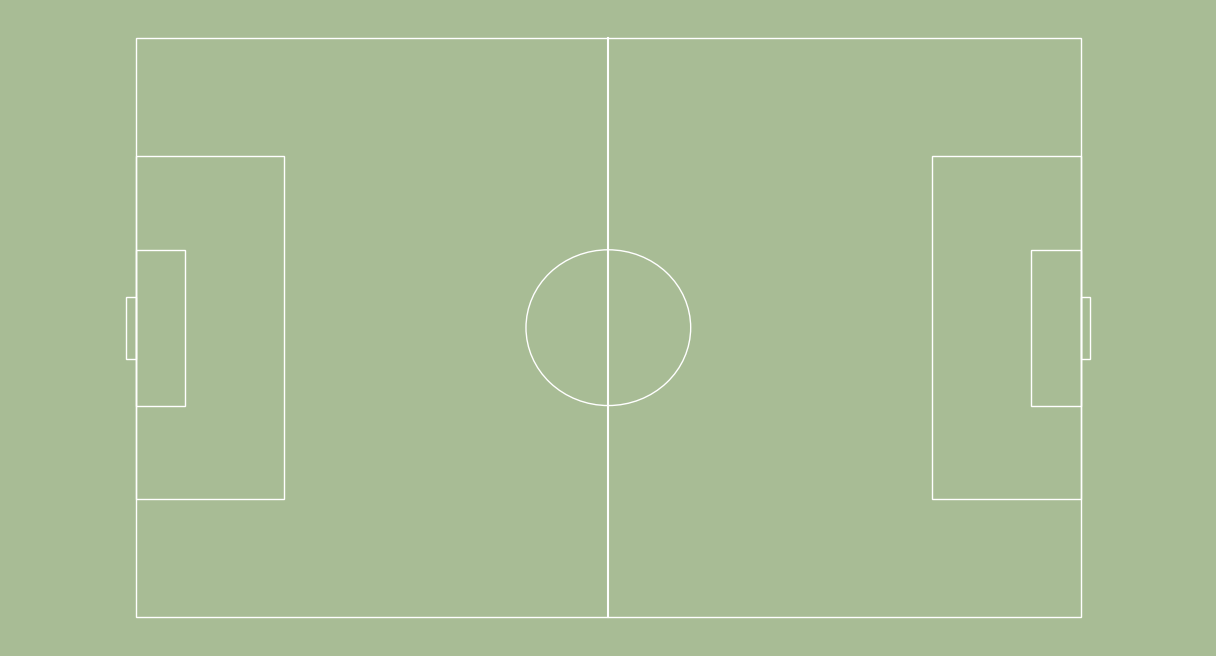

In [4]:
X_SIZE = 105.0
Y_SIZE = 68.0

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100

SCALERS = np.array([X_SIZE/100, Y_SIZE/100])

def draw_pitch(dpi=100):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """

    fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi) #(X_SIZE/10, Y_SIZE/10)
    fig.patch.set_facecolor('#a8bc95') #complementary: #80a260 e #95bbbc, opposing: #bc95a8 & #bc9f95

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor('#a8bc95')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0,100)
    axes.set_ylim(0,100)

    plt.xlim([-13.32, 113.32])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_patches(axes)

    return fig, axes

def draw_patches(axes):
    """
    Draws basic field shapes on an axes
    """
    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none"))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))

    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))

    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))


    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes

draw_pitch()

0

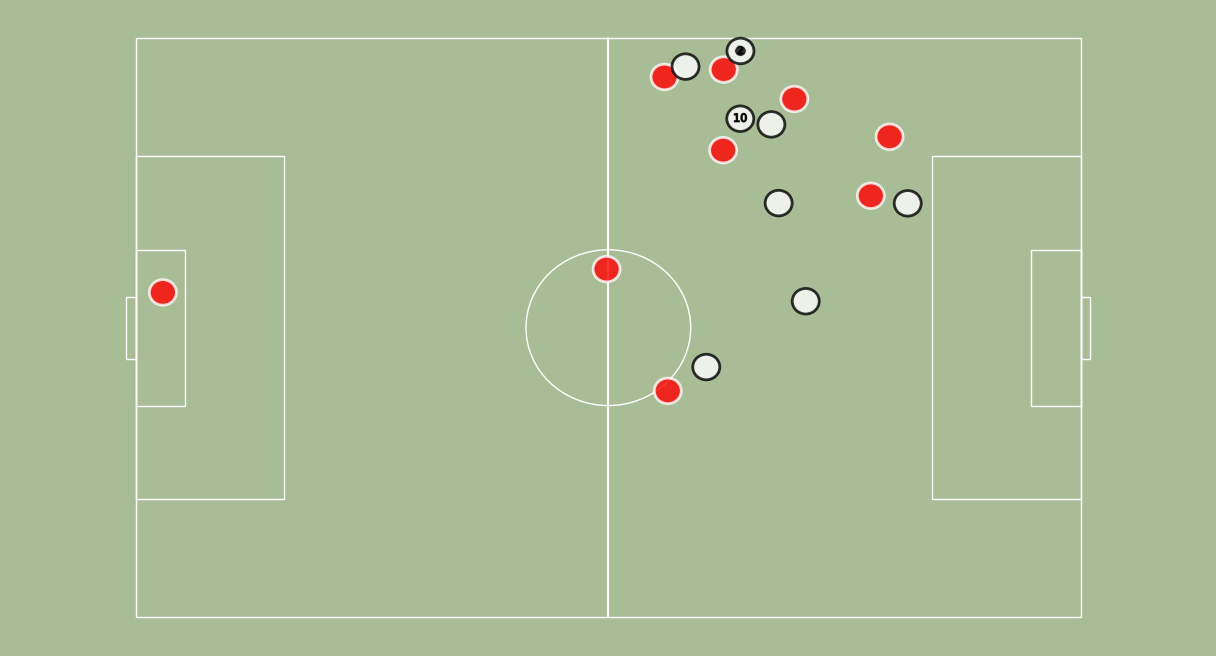

In [5]:
def draw_frame(df, dfPlayers, t, text_color='black'):
    f = int(t*20)
    fig, ax = draw_pitch()
    dfFrame = df.loc[f]

    for pid in dfFrame.index:
        if pid==0:
            #formatting for ball (id==0)
            try:
                z = dfFrame.loc[pid]['z']
            except:
                z = 0
            size = 1.3+z
            lw = 0.7
            color='black'
            edge='white'
            zorder = 100
        else:
            #formatting for players
            size = 3
            lw = 2
            edge =  dfPlayers.loc[pid]['edgecolor']

            color = dfPlayers.loc[pid]['bgcolor']
            if dfPlayers.loc[pid]['team']=='attack':
                zorder = 21
            else:
                zorder = 20

        ax.add_artist(Ellipse((dfFrame.loc[pid]['x'],
                               dfFrame.loc[pid]['y']),
                              size/X_SIZE*100, size/Y_SIZE*100,
                              edgecolor=edge,
                              linewidth=lw,
                              facecolor=color,
                              alpha=0.8,
                              zorder=zorder))

        if pid!=0:
            s = dfPlayers.loc[pid]['player_num']
            if not(pd.isnull(s)):
                if isinstance(s, float):
                    s=int(s)
                text = plt.text(dfFrame.loc[pid]['x'],dfFrame.loc[pid]['y'],str(s),
                                horizontalalignment='center', verticalalignment='center',
                                fontsize=8, color=text_color, zorder=22, alpha=0.8)

                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
                                       path_effects.Normal()])

    return fig, ax, dfFrame


draw_frame(df, dfPlayers, t=3.5)

0

In [6]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint
from shapely import affinity

from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi


0

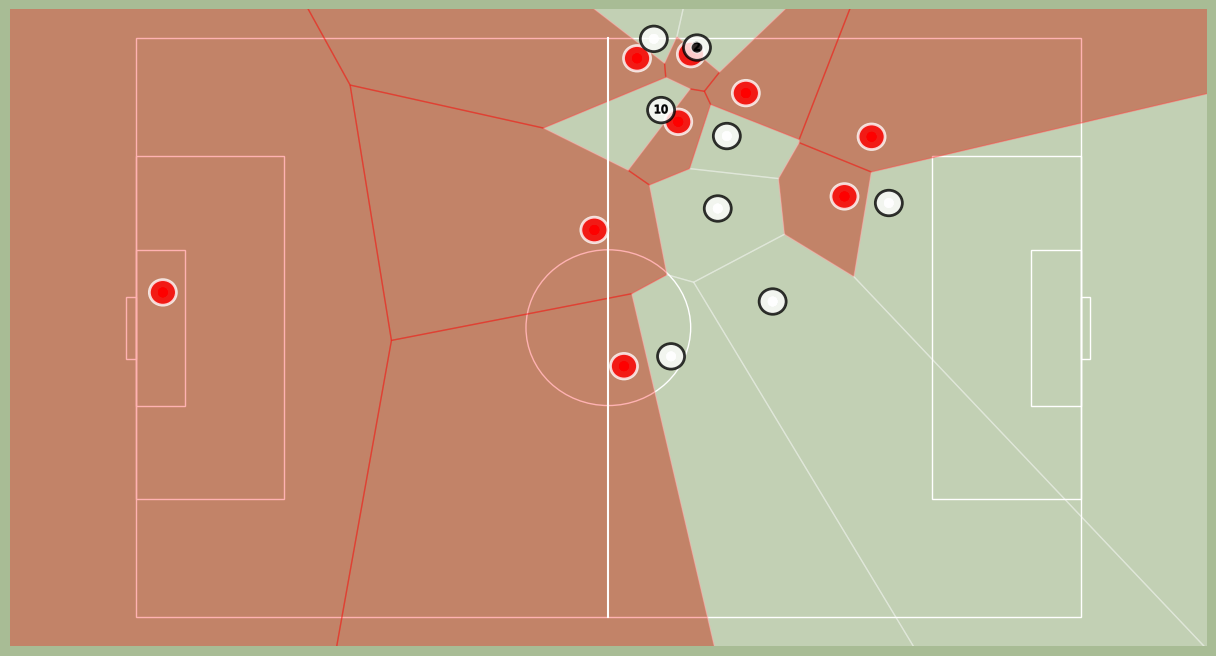

In [7]:
direction = -1

def draw_voronoi(df, dfPlayers, t):
    fig, ax, dfFrame = draw_frame(df, dfPlayers, t)
    vor, dfVor = calculate_voronoi(dfFrame, dfPlayers)
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS)
                    color = pl['bgcolor'].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                except IndexError:
                    pass
                except AttributeError:
                    pass

        plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)
    return fig, ax, dfFrame

def calculate_voronoi(dfFrame, dfPlayers):
    dfTemp = dfFrame.copy().drop(0, errors='ignore').join(dfPlayers, rsuffix='_dup')

    values = np.vstack((dfTemp[['x', 'y']].values*SCALERS,
                        [-1000,-1000],
                        [+1000,+1000],
                        [+1000,-1000],
                        [-1000,+1000]
                       ))

    vor = Voronoi(values)

    dfTemp['region'] = vor.point_region[:-4]

    return vor, dfTemp


draw_voronoi(df, dfPlayers, t=4.9)

0

0

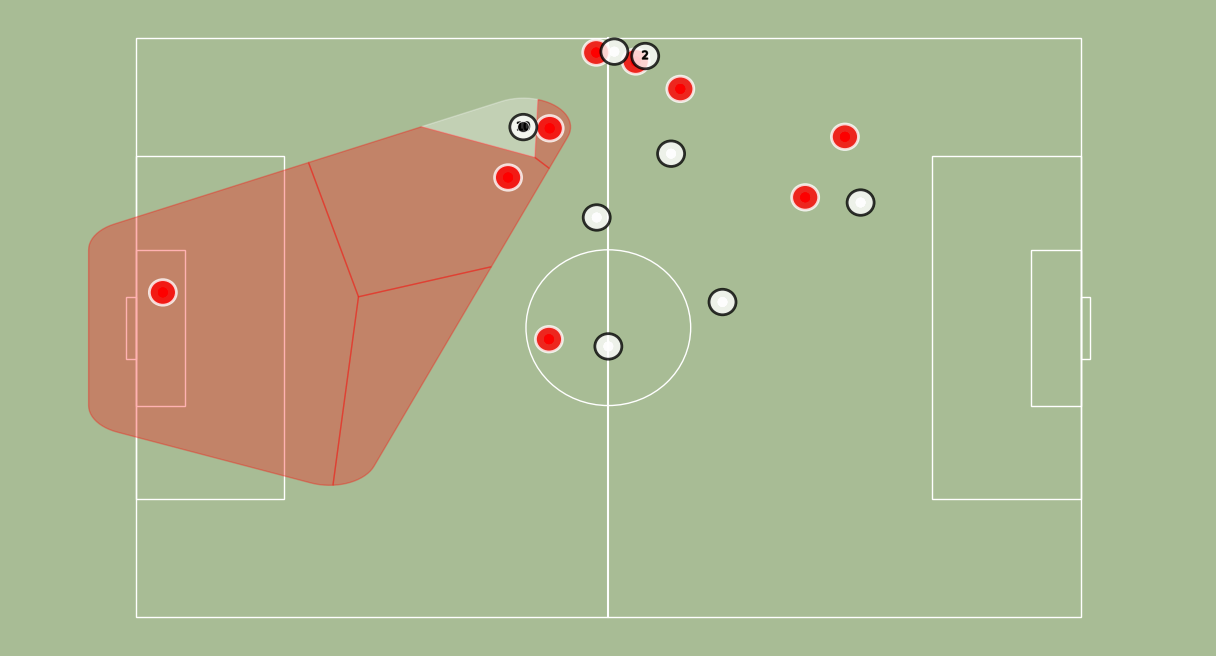

In [28]:
direction = -1

def draw_voronoi(df, dfPlayers, t):
    fig, ax, dfFrame = draw_frame(df, dfPlayers, t)

    #defining the area of interest
    ball_x_coord = dfFrame.loc[0]['x']
    dangerpoints = np.array([[50+direction*50, (100-GOAL_AREA_HEIGHT)/2],
                           [50+direction*50, (100+GOAL_AREA_HEIGHT)/2],
                           [50+direction*(50-ball_x_coord/2), 100/2],
                           [50+direction*(50-ball_x_coord/2), (100-(1.5*BOX_HEIGHT)/2)/2],
                           [50+direction*(50-ball_x_coord/2), (100+(1.5*BOX_HEIGHT)/2)/2]
                          ])
    
    polygon_danger = Polygon(dangerpoints)
    x, y = polygon_danger.exterior.xy

    points = np.vstack([dfFrame.loc[0][['x','y']].values,
                        dangerpoints
                       ])

    polygon_of_interest = Polygon(points[ConvexHull(points).vertices]).buffer(5)

    vor, dfVor = calculate_voronoi(dfFrame, dfPlayers)
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS)
                    polygon_interest = polygon.intersection(polygon_of_interest)
                    color = pl['bgcolor'].values[0]
                    x, y = polygon_interest.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                except IndexError:
                    pass
                except AttributeError:
                    pass

        plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)
    return fig, ax, dfFrame

def calculate_voronoi(dfFrame, dfPlayers):
    dfTemp = dfFrame.copy().drop(0, errors='ignore').join(dfPlayers, rsuffix='_dup')

    values = np.vstack((dfTemp[['x', 'y']].values*SCALERS,
                        #adding far away points guarantee that the whole pitch is covered by the voronoi
                        [-1000,-1000], 
                        [+1000,+1000],
                        [+1000,-1000],
                        [-1000,+1000]
                       ))

    vor = Voronoi(values)

    dfTemp['region'] = vor.point_region[:-4]

    return vor, dfTemp


draw_voronoi(df, dfPlayers, t=7)

0